# Wavelets

pooling:  
https://numbersmithy.com/2d-and-3d-pooling-using-numpy/



https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/  

https://github.com/taspinar/siml

The general rule is that this approach of using the Fourier Transform will work very well when the frequency spectrum is stationary. That is, the frequencies present in the signal are not time-dependent; if a signal contains a frequency of x Hz this frequency should be present equally anywhere in the signal.

The main problem with this approach is that you run into the theoretical limits of the Fourier Transform known as the uncertainty principle. The smaller we make the size of the window the more we will know about where a frequency has occurred in the signal, but less about the frequency value itself. The larger we make the size of the window the more we will know about the frequency value and less about the time.

EDG: what if I use sfft for the 50 seconds sample to grab all frequencies, and then do sfft for small chunks and compare the resulting frequencies with the ones in the complete sample? (this is what wavelets do)

The Wavelet Transform has:
- for small frequency values a high resolution in the frequency domain, low resolution in the time- domain,
- for large frequency values a low resolution in the frequency domain, high resolution in the time domain.

The best way to choose the right wavelet is to do a lot of trial-and-error and a little bit of literature research.






Daubechies order 4
wavelet was found to be the most appropriate for
analysis of epileptic EEG data. (2003, Adeli, pag 17)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from scipy.signal import sosfiltfilt, butter


base_dir = "../../kaggle_data/hms"
# base_dir = "../../data/hms"
# base_dir = "/kaggle/input/hms-harmful-brain-activity-classification"

data_dir = '../data'
# data_dir = '/kaggle/input/hms-indices-train-val-test-v1'

output_dir = '../data/'
# output_dir = ''

fs = 200  # Sample rate.

df_traincsv = pd.read_csv(f'{base_dir}/train.csv')

TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

df_traincsv = pd.read_csv(f'{base_dir}/train.csv')
df_traincsv.loc[df_traincsv.expert_consensus == 'Seizure', 'target'] = 0
df_traincsv.loc[df_traincsv.expert_consensus == 'LPD', 'target'] = 1
df_traincsv.loc[df_traincsv.expert_consensus == 'GPD', 'target'] = 2
df_traincsv.loc[df_traincsv.expert_consensus == 'LRDA', 'target'] = 3
df_traincsv.loc[df_traincsv.expert_consensus == 'GRDA', 'target'] = 4
df_traincsv.loc[df_traincsv.expert_consensus == 'Other', 'target'] = 5

# Transform votes into percentages.
df_traincsv['sum_votes'] = df_traincsv.seizure_vote + df_traincsv.lpd_vote + df_traincsv.gpd_vote	+ df_traincsv.lrda_vote + df_traincsv.grda_vote + df_traincsv.other_vote
df_traincsv['seizure_vote'] = df_traincsv.seizure_vote/df_traincsv.sum_votes
df_traincsv['lpd_vote'] = df_traincsv.lpd_vote/df_traincsv.sum_votes
df_traincsv['gpd_vote'] = df_traincsv.gpd_vote/df_traincsv.sum_votes
df_traincsv['lrda_vote'] = df_traincsv.lrda_vote/df_traincsv.sum_votes
df_traincsv['grda_vote'] = df_traincsv.grda_vote/df_traincsv.sum_votes
df_traincsv['other_vote'] = df_traincsv.other_vote/df_traincsv.sum_votes

idxs_train = np.load(f'{data_dir}/03_stratified_v2_idxs_train.npy')
idxs_val = np.load(f'{data_dir}/03_stratified_v2_idxs_val.npy')
idxs_test = np.load(f'{data_dir}/03_stratified_v2_idxs_test.npy')
df_train = df_traincsv.loc[idxs_train]
df_val = df_traincsv.loc[idxs_val]
df_test = df_traincsv.loc[idxs_test]

print("Added target column. Transformed into percentages.")
print("Train:", len(df_train))
print("Val:", len(df_val))
print("Test:", len(df_test))


Added target column. Transformed into percentages.
Train: 12186
Val: 2148
Test: 1248


## Definitions

In [63]:
# 2024022800
def banana(eeg_absolute, filter=False, fs=200.0):
    '''Returns pandas dataframe with a banana montage.

    filter: False or [low freq, high freq]
    '''
    if filter:
        filtered_data = eeg_absolute.copy()
        # Apply band pass.
        sos = butter(5, filter, btype='bandpass', fs=fs, output='sos')
        for c in filtered_data.columns:
            filtered_data[c] = sosfiltfilt(sos, filtered_data[c])
    else:
        filtered_data = eeg_absolute.copy()

    eeg = pd.DataFrame(data={
        'Fp1-F7' : filtered_data.Fp1 - filtered_data.F7,
        'Fp7-T3' : filtered_data.F7 - filtered_data.T3,
        'T3-T5' : filtered_data.T3 - filtered_data.T5,
        'T5-O1' : filtered_data.T5 - filtered_data.O1,

        'Fp2-F8' : filtered_data.Fp2 - filtered_data.F8,
        'F8-T4' : filtered_data.F8 - filtered_data.T4,
        'T4-T6' : filtered_data.T4 - filtered_data.T6,
        'T6-O2' : filtered_data.T6 - filtered_data.O2,

        'Fp1-F3' : filtered_data.Fp1 - filtered_data.F3,
        'F3-C3' : filtered_data.F3 - filtered_data.C3,
        'C3-P3' : filtered_data.C3 - filtered_data.P3,
        'P3-O1' : filtered_data.P3 - filtered_data.O1,

        'Fp2-F4' : filtered_data.Fp2 - filtered_data.F4,
        'F4-C4' : filtered_data.F4 - filtered_data.C4,
        'C4-P4' : filtered_data.C4 - filtered_data.P4,
        'P4-O2' : filtered_data.P4 - filtered_data.O2,

        'Fz-Cz' : filtered_data.Fz - filtered_data.Cz,
        'Cz-Pz' : filtered_data.Cz - filtered_data.Pz,

        'EKG' : filtered_data.EKG
        })
    return eeg

# 20240303
def poolingOverlap(mat, f, stride=None, method='max', pad=False,
                   return_max_pos=False):
    '''Overlapping pooling on 2D or 3D data.

    Args:
        mat (ndarray): input array to do pooling on the first 2 dimensions.
        f (int): pooling kernel size.
    Keyword Args:
        stride (int or None): stride in row/column. If None, same as <f>,
            i.e. non-overlapping pooling.
        method (str): 'max for max-pooling,
                      'mean' for average-pooling.
        pad (bool): pad <mat> or not. If true, pad <mat> at the end in
               y-axis with (f-n%f) number of nans, if not evenly divisible,
               similar for the x-axis.
        return_max_pos (bool): whether to return an array recording the locations
            of the maxima if <method>=='max'. This could be used to back-propagate
            the errors in a network.
    Returns:
        result (ndarray): pooled array.

    See also unpooling().
    '''
    m, n = mat.shape[:2]
    if stride is None:
        stride = f
    _ceil = lambda x, y: x//y + 1

    if pad:
        ny = _ceil(m, stride)
        nx = _ceil(n, stride)
        size = ((ny-1)*stride+f, (nx-1)*stride+f) + mat.shape[2:]
        mat_pad = np.full(size, 0)
        mat_pad[:m, :n, ...] = mat
    else:
        mat_pad = mat[:(m-f)//stride*stride+f, :(n-f)//stride*stride+f, ...]

    view = asStride(mat_pad, (f, f), stride)
    if method == 'max':
        result = np.nanmax(view, axis=(2, 3), keepdims=return_max_pos)
    else:
        result = np.nanmean(view, axis=(2, 3), keepdims=return_max_pos)

    if return_max_pos:
        pos = np.where(result == view, 1, 0)
        result = np.squeeze(result)
        return result, pos
    else:
        return result

# 20240303
def asStride(arr, sub_shape, stride):
    '''Get a strided sub-matrices view of an ndarray.

    Args:
        arr (ndarray): input array of rank 2 or 3, with shape (m1, n1) or (m1, n1, c).
        sub_shape (tuple): window size: (m2, n2).
        stride (int): stride of windows in both y- and x- dimensions.
    Returns:
        subs (view): strided window view.

    See also skimage.util.shape.view_as_windows()
    '''
    s0, s1 = arr.strides[:2]
    m1, n1 = arr.shape[:2]
    m2, n2 = sub_shape[:2]

    view_shape = (1+(m1-m2)//stride, 1+(n1-n2)//stride, m2, n2)+arr.shape[2:]
    strides = (stride*s0, stride*s1, s0, s1)+arr.strides[2:]
    subs = np.lib.stride_tricks.as_strided(
        arr, view_shape, strides=strides, writeable=False)

    return subs

## Playing with cwt

In [17]:
# Grabs 50 second sub sample
# Interpolates (removes NaN) and builds banana montage.

eeg_id = 493696785
eeg_sub_id = 3  # seizure
item = df_traincsv.loc[(df_traincsv.eeg_id == eeg_id) & (df_traincsv.eeg_sub_id == eeg_sub_id)].iloc[0]
eeg_full = pd.read_parquet(f'{base_dir}/train_eegs/{eeg_id}.parquet')
# 50 second eeg sub sample
offset = int(item.eeg_label_offset_seconds)
start = offset * fs
end = (offset + 50) * fs
eeg_absolute = eeg_full[start:end]
eeg_absolute = eeg_absolute.interpolate(limit_direction='both') # <<<<< Interpolation
eeg = banana(eeg_absolute, filter=[1,70])
columns = eeg.columns
item

eeg_id                               493696785
eeg_sub_id                                   3
eeg_label_offset_seconds                  46.0
spectrogram_id                       458831369
spectrogram_sub_id                           3
spectrogram_label_offset_seconds          46.0
label_id                            1547083774
patient_id                               42180
expert_consensus                       Seizure
seizure_vote                               1.0
lpd_vote                                   0.0
gpd_vote                                   0.0
lrda_vote                                  0.0
grda_vote                                  0.0
other_vote                                 0.0
target                                     0.0
sum_votes                                    3
Name: 23571, dtype: object

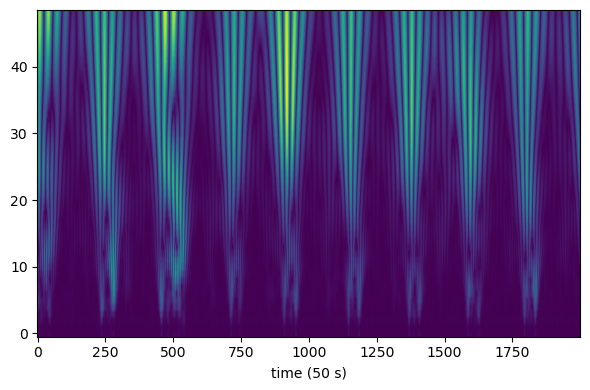

(49, 2000)


In [21]:
N = eeg.shape[0]
t0=0
dt=1.0/fs
time = np.arange(0, N) * dt + t0
signal = eeg.iloc[:,0]
scales = range(1,50)
waveletname = 'morl'
sampling_period = 1

coeff, freq = pywt.cwt(signal, scales, waveletname, sampling_period=sampling_period)

coeff = coeff[:,2000:4000]

x = (coeff - np.mean(coeff)) / np.std(coeff)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.imshow(abs(x), origin='lower', aspect='auto')
ax.set_xlabel('time (50 s)')

plt.tight_layout()
plt.show()
print(coeff.shape)



## Single file for cwt

In [27]:

fmin = 1
fmax = 50
scales = np.arange(1,50)
waveletname = 'morl'
# train_size = len(df_train)
train_size = 100
val_size = len(df_val)
test_size= len(df_test)
n_channels = 5
dim1 = scales.shape[0]
dim2 = 2000
sampling_period = 1

sgrams = np.empty((train_size, dim1, dim2, n_channels))
# item: [eeg_id, eeg_sub_id, idx in sgrams (1st index), target,
#       seizure_vote, lpd_vote, gpd_vote, lrda_vote,
#       grda_vote, other_vote]
items = np.array([], dtype=float).reshape(0,10)

for i in range(train_size):
    # if i % 1000 == 0:
    if i % 10 == 0:
        print(f'{i} eegs loaded', end='\r')
    item = df_train.iloc[i]
    eeg_full = pd.read_parquet(f'{base_dir}/train_eegs/{item.eeg_id}.parquet')
    # 50 second eeg sub sample
    offset = int(item.eeg_label_offset_seconds)
    start = offset * fs
    end = (offset + 50) * fs
    eeg_absolute = eeg_full[start:end]
    eeg_absolute = eeg_absolute.interpolate(limit_direction='both') # <<<<< Interpolation
    eeg = banana(eeg_absolute, filter=[fmin,fmax])

    # X = np.empty((1, dim1, dim2, n_channels))
    # Averaging each chain in the banana montage.

    # Left temporal chain.
    coeff = np.empty((dim1, dim2))
    for col in [0,1,2,3]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_[:,2000:4000]  # Saving only central 10 seconds.
        coeff = coeff/4
    x = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,0] = x.copy()

    # Right temporal chain.
    coeff = np.empty((dim1, dim2))
    for col in [4,5,6,7]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_[:,2000:4000]  # Saving only central 10 seconds.
        coeff = coeff/4
    x = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,1] = x.copy()

    # Left parasagittal chain.
    coeff = np.empty((dim1, dim2))
    for col in [8,9,10,11]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_[:,2000:4000]  # Saving only central 10 seconds.
        coeff = coeff/4
    x = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,2] = x.copy()

    # Right parasagittal chain.
    coeff = np.empty((dim1, dim2))
    for col in [12,13,14,15]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_[:,2000:4000]  # Saving only central 10 seconds.
        coeff = coeff/4
    x = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,3] = x.copy()

    # Central chain.
    coeff = np.empty((dim1, dim2))
    for col in [16,17]:
        coeff_, freq = pywt.cwt(eeg.iloc[:,col], scales, waveletname, sampling_period=sampling_period)
        coeff = coeff + coeff_[:,2000:4000]  # Saving only central 10 seconds.
        coeff = coeff/2
    x = (coeff - np.mean(coeff)) / np.std(coeff)
    sgrams[i,:,:,4] = x.copy()

    xitem = np.array([item.eeg_id, item.eeg_sub_id, i, item.target,
                    item.seizure_vote, item.lpd_vote, item.gpd_vote,
                    item.lrda_vote, item.grda_vote, item.other_vote],
                    dtype=float).reshape(1,10)
    items = np.concatenate([items, xitem])

filename = '05_single_cwt_v1_train'     
print(f'Saving to {filename}.npy')
print(f'Saving to {filename}_items.npy')
np.save(f'{output_dir}{filename}.npy', sgrams)
np.save(f'{output_dir}{filename}_items.npy', items)



Saving to 05_single_cwt_v1_train.npy
Saving to 05_single_cwt_v1_train_items.npy


In [28]:
train_size = 1000
dim1 = 49
dim2 = 2000
n_channels = 5
sgrams = np.empty((train_size, dim1, dim2, n_channels))
np.save(f'{output_dir}{filename}.npy', sgrams)


Testing output.

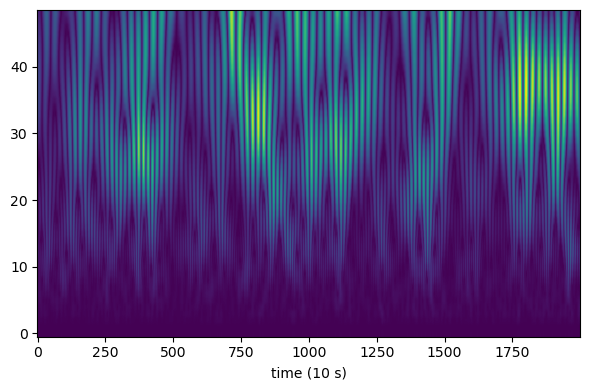

(49, 2000)


In [24]:

x = sgrams[10,:,:,0]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.imshow(abs(x), origin='lower', aspect='auto')
ax.set_xlabel('time (10 s)')

plt.tight_layout()
plt.show()
print(coeff.shape)



In [57]:
# Import numpy
import numpy as np

# Creating a numpy matrix
mat = np.array([[  1,  10,   1,  20, 1, 30, 1, 40],
                [ 2,  2,  2,  2, 4, 4, 4, 4],
       [ 3,   3,   3,  3, 5, 5, 5, 5],
       [4,   4,   4,   4, 8,8,8,8]])
# mat = coeff[:,0:200]

# Display original matrix
print("Original matrix:\n",mat,"\n")

# Getting shape of matrix
M, N = mat.shape

# Shape of kernel
K = 1
L = 3

# Dividing the image size by kernel size
MK = M // K
NL = N // L

# Creating a pool
res = mat[:MK*K, :NL*L].reshape(MK, K, NL, L).max(axis=0)

# Display Result
print("Result:\n",res)

print(mat.shape)
print(res.shape)


Original matrix:
 [[ 1 10  1 20  1 30  1 40]
 [ 2  2  2  2  4  4  4  4]
 [ 3  3  3  3  5  5  5  5]
 [ 4  4  4  4  8  8  8  8]] 

Result:
 [[[ 4 10  4]
  [20  8 30]]]
(4, 8)
(1, 2, 3)


In [58]:
mat[:MK*K, :NL*L].reshape(MK, K, NL, L)

array([[[[ 1, 10,  1],
         [20,  1, 30]]],


       [[[ 2,  2,  2],
         [ 2,  4,  4]]],


       [[[ 3,  3,  3],
         [ 3,  5,  5]]],


       [[[ 4,  4,  4],
         [ 4,  8,  8]]]])

In [62]:
mat[:MK*K, :NL*L].reshape(MK, K, NL, L).max(axis=(1,3))

array([[10, 30],
       [ 2,  4],
       [ 3,  5],
       [ 4,  8]])

In [39]:
mat[0:3,0:20]

array([[-2.70610490e-01,  7.59379952e-01,  1.34867088e+00,
         7.61931459e-01, -3.97775312e-01, -9.11128353e-01,
        -6.49165687e-01, -4.06117561e-01, -1.15182070e-02,
         8.66287884e-01,  1.04597489e+00, -2.96041475e-01,
        -1.64454602e+00, -1.31812797e+00,  1.68907169e-01,
         1.25602882e+00,  1.18158503e+00,  2.55637926e-01,
        -5.29058145e-01, -4.29258530e-01],
       [ 6.73049666e-02,  1.43670231e-03, -1.66123506e-01,
        -1.52525903e-01,  2.10741862e-01,  1.83324695e-01,
        -2.55866901e-01, -8.80015248e-02,  3.50078091e-01,
        -6.73907569e-03, -4.31657460e-01, -7.58458158e-03,
         3.71117653e-01,  7.31710620e-02, -1.59210850e-01,
        -6.89676525e-02, -6.91462174e-02, -2.35381827e-02,
         1.84550817e-01,  9.57483515e-02],
       [ 1.62894193e+00, -5.72019138e-01, -2.09894949e+00,
        -5.54749434e-01,  1.67929928e+00,  7.77861709e-01,
        -1.17565704e+00,  9.75856251e-02,  1.79844509e+00,
        -5.61826172e-01, -3.0

In [40]:
res[0:3,0:10]

array([[ 0.4403193 , -0.22232838, -0.40876668,  0.34698702, -0.20906685,
         0.2129731 , -0.08784666,  0.0907938 ,  0.33052046, -0.3952521 ],
       [-0.00783318,  0.03655906, -0.03083284,  0.02372942, -0.04656883,
         0.00178849,  0.05400632, -0.02702212, -0.12473956,  0.05436384],
       [ 0.01650463,  0.18728184,  0.06288437, -0.00908507, -0.26542094,
         0.0066975 ,  0.15221109, -0.4105834 , -0.61098196,  0.4415757 ]])

In [68]:
n = 6
f = 3
s = 2

np.random.seed(100)
mat = np.random.randint(0, 20, [n, n])
print('mat.shape:', mat.shape, 'filter size:', f, 'stride:', s)
print(mat)

po, pos = poolingOverlap(mat, f, stride=s, pad=False, return_max_pos=True)
print('Overlap pooling, no pad. Result shape:', po.shape)
print(po)

print('Max position pos.shape:')
print(pos.shape)
print('Max position in the (0,0) window:')
print(pos[0, 0])
print('Max position in the (0,1) window:')
print(pos[0, 1])

mat.shape: (6, 6) filter size: 3 stride: 2
[[ 8  3  7 15 16 10]
 [ 2  2  2 14  2 17]
 [16 15  4 11 16  9]
 [ 2 12  4  1 13 19]
 [ 4  4  3  7 17 15]
 [ 1 14  7 16  2  9]]
Overlap pooling, no pad. Result shape: (2, 2)
[[16 16]
 [16 17]]
Max position pos.shape:
(2, 2, 3, 3)
Max position in the (0,0) window:
[[0 0 0]
 [0 0 0]
 [1 0 0]]
Max position in the (0,1) window:
[[0 0 1]
 [0 0 0]
 [0 0 1]]
